# Packing Density Analysis: Did the Core Crystallize?

We know the cluster underwent thermal motion during training before freezing on the bfloat16 lattice. The question: what structure did it condense into?

Strategy:
- Use the 814-token black hole (largest population) as our origin
- Measure L∞ distance from origin to every other unique vector
- Look for discrete shells at integer ULP radii (signature of crystallization)
- Identify the solid core (densely packed) vs halo (sparse outliers)

If we see discrete shells with high occupancy → we have a crystal.
If continuous distribution → we have a frozen gas.

## Parameters

In [35]:
# Paths
CLUSTER_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.4h_cluster_tokens.safetensors'
GAMMA_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'

# Visualization
DPI = 200
SHOW_TOP_N_SHELLS = 20  # Show first N shells in detail

## Imports

In [36]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from collections import defaultdict

## Device Detection

In [37]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Data

In [38]:
# Load cluster token IDs
cluster_data = load_file(CLUSTER_TOKENS_PATH)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f'Loaded {len(cluster_token_ids)} cluster token IDs')

Loaded 2212 cluster token IDs


In [39]:
# Load gamma matrix in bfloat16
gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.bfloat16).to(device)

print(f'Loaded gamma matrix: {W.shape}')
print(f'Precision: {W.dtype}')

Loaded gamma matrix: torch.Size([151936, 2560])
Precision: torch.bfloat16


In [40]:
# Extract cluster vectors
cluster_vectors = W[cluster_token_ids]

print(f'Extracted {cluster_vectors.shape[0]} vectors of dimension {cluster_vectors.shape[1]}')

Extracted 2212 vectors of dimension 2560


## Find Unique Vectors and Populations

In [41]:
# Find unique vectors (stay in bfloat16)
unique_vectors, inverse_indices = torch.unique(cluster_vectors.to('cpu'), dim=0, return_inverse=True)
unique_vectors = unique_vectors.to(device)
inverse_indices = inverse_indices.to(device)

populations = torch.bincount(inverse_indices)

print(f'Found {len(unique_vectors)} unique vectors')
print(f'Precision: {unique_vectors.dtype}')
print(f'Population range: {populations.min().item()} to {populations.max().item()}')

Found 125 unique vectors
Precision: torch.bfloat16
Population range: 1 to 814


## Identify the Big One (814-token black hole)

In [42]:
# Find the most populated vector
big_one_idx = torch.argmax(populations).item()
big_one_population = populations[big_one_idx].item()
big_one_vector = unique_vectors[big_one_idx]

print(f'The Big One:')
print(f'  Index: {big_one_idx}')
print(f'  Population: {big_one_population} tokens')
print(f'  Vector norm: {torch.norm(big_one_vector.to(torch.float32)).item():.6f}')
print(f'\nUsing this as our origin for L∞ distance measurements.')

The Big One:
  Index: 60
  Population: 814 tokens
  Vector norm: 0.370917

Using this as our origin for L∞ distance measurements.


## Compute L∞ Distances from Big One

In [43]:
# Compute L∞ (Chebyshev) distance from Big One to all unique vectors
# L∞ = max over all dimensions of |difference|
differences = unique_vectors - big_one_vector
linf_distances = torch.max(torch.abs(differences), dim=1)[0]

# Convert to float32 for analysis
linf_distances_f32 = linf_distances.to(torch.float32).cpu().numpy()
populations_np = populations.cpu().numpy()

print(f'L∞ distance range: [{linf_distances_f32.min():.6e}, {linf_distances_f32.max():.6e}]')
print(f'Mean L∞ distance: {linf_distances_f32.mean():.6e}')
print(f'Median L∞ distance: {np.median(linf_distances_f32):.6e}')

L∞ distance range: [0.000000e+00, 4.882812e-04]
Mean L∞ distance: 2.449435e-05
Median L∞ distance: 3.051758e-05


## Compute ULP at Big One

In [44]:
def bfloat16_ulp(x):
    """
    Compute the Unit in Last Place (ULP) for bfloat16 at value x.
    bfloat16: 1 sign + 8 exponent + 7 mantissa bits
    """
    if x == 0:
        return 2**(-133)  # Smallest subnormal
    exponent = int(np.floor(np.log2(np.abs(x))))
    return 2**(exponent - 7)

# Compute ULP at a typical component value from Big One
big_one_f32 = big_one_vector.to(torch.float32).cpu().numpy()
typical_value = np.median(np.abs(big_one_f32[big_one_f32 != 0]))
ulp_at_origin = bfloat16_ulp(typical_value)

print(f'Typical component magnitude in Big One: {typical_value:.6e}')
print(f'ULP at this scale: {ulp_at_origin:.6e}')
print(f'\nFor reference:')
print(f'  1 ULP = {ulp_at_origin:.6e}')
print(f'  Max distance = {linf_distances_f32.max() / ulp_at_origin:.1f} ULP')

Typical component magnitude in Big One: 3.585815e-03
ULP at this scale: 1.525879e-05

For reference:
  1 ULP = 1.525879e-05
  Max distance = 32.0 ULP


## Normalize Distances to ULP Units

In [45]:
# Express distances in ULP units
distances_in_ulp = linf_distances_f32 / ulp_at_origin

print(f'Distances in ULP units:')
print(f'  Range: [{distances_in_ulp.min():.2f}, {distances_in_ulp.max():.2f}]')
print(f'  Mean: {distances_in_ulp.mean():.2f}')
print(f'  Median: {np.median(distances_in_ulp):.2f}')

Distances in ULP units:
  Range: [0.00, 32.00]
  Mean: 1.61
  Median: 2.00


## Shell Analysis: Occupancy by Integer ULP Radius

In [46]:
# Round to nearest integer ULP
shell_indices = np.round(distances_in_ulp).astype(int)

# Count vectors in each shell
shell_counts = defaultdict(int)
shell_populations = defaultdict(int)

for shell_idx, population in zip(shell_indices, populations_np):
    shell_counts[shell_idx] += 1  # Number of unique vectors
    shell_populations[shell_idx] += population  # Total tokens

# Convert to sorted arrays
shells = sorted(shell_counts.keys())
counts = [shell_counts[s] for s in shells]
pops = [shell_populations[s] for s in shells]

print(f'Shell structure:')
print(f'  Number of shells: {len(shells)}')
print(f'  Shell radius range: {min(shells)} to {max(shells)} ULP')
print(f'\nFirst {SHOW_TOP_N_SHELLS} shells:')
print(f'  {"Shell":>5} {"Vectors":>8} {"Tokens":>8} {"Cumulative":>12}')
print(f'  {"-" * 5} {"-" * 8} {"-" * 8} {"-" * 12}')

cumulative_vectors = 0
cumulative_tokens = 0
for i, shell in enumerate(shells[:SHOW_TOP_N_SHELLS]):
    cumulative_vectors += counts[i]
    cumulative_tokens += pops[i]
    print(f'  {shell:5d} {counts[i]:8d} {pops[i]:8d} {cumulative_vectors:6d}/{cumulative_tokens:5d}')

Shell structure:
  Number of shells: 6
  Shell radius range: 0 to 32 ULP

First 20 shells:
  Shell  Vectors   Tokens   Cumulative
  ----- -------- -------- ------------
      0       34      852     34/  852
      1       24      270     58/ 1122
      2       61     1081    119/ 2203
      3        3        3    122/ 2206
      4        2        5    124/ 2211
     32        1        1    125/ 2212


## Histogram: Distance Distribution

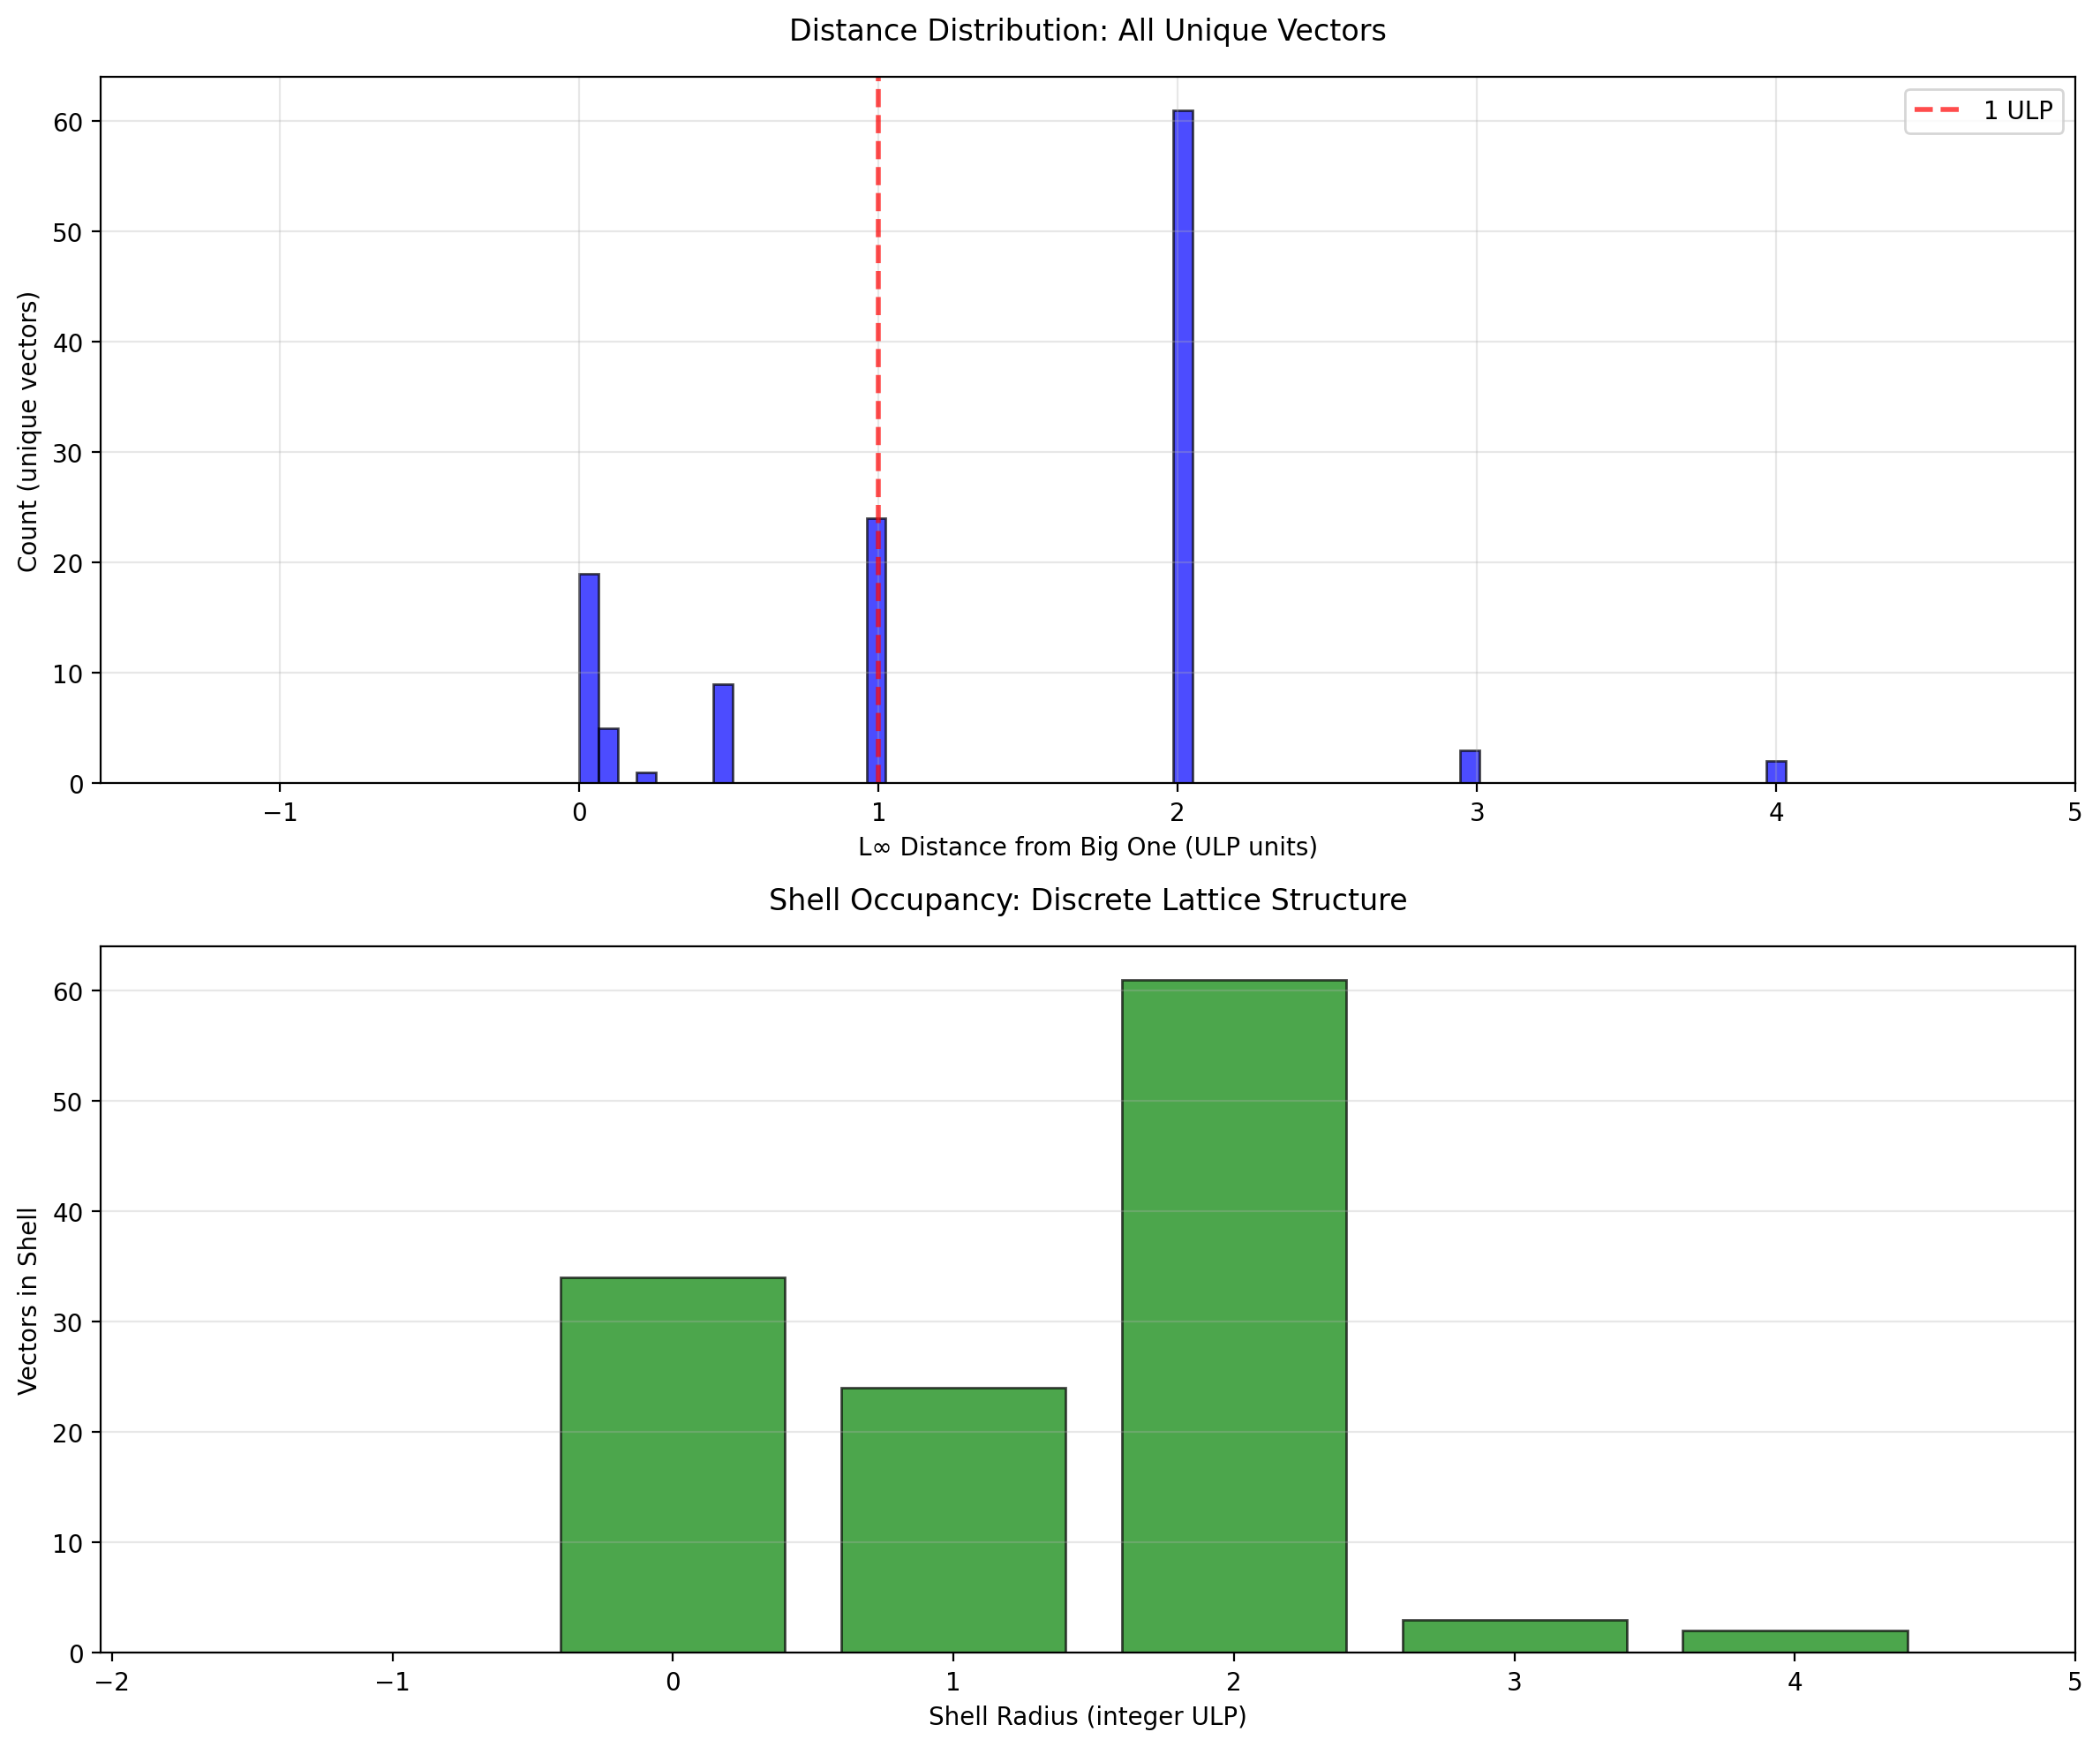

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=DPI)

# Top: Raw distances in ULP units
ax1.hist(distances_in_ulp, bins=500, color='blue', alpha=0.7, edgecolor='black')
ax1.axvline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='1 ULP')
ax1.set_xlabel('L∞ Distance from Big One (ULP units)', color='black')
ax1.set_ylabel('Count (unique vectors)', color='black')
ax1.set_title('Distance Distribution: All Unique Vectors', color='black', pad=15)
ax1.tick_params(colors='black')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax1.set_xlim(right=5)

# Bottom: Shell occupancy (integer ULP radii)
ax2.bar(shells, counts, color='green', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Shell Radius (integer ULP)', color='black')
ax2.set_ylabel('Vectors in Shell', color='black')
ax2.set_title('Shell Occupancy: Discrete Lattice Structure', color='black', pad=15)
ax2.tick_params(colors='black')
ax2.grid(True, alpha=0.3, axis='y')

ax2.set_xlim(right=5)

plt.tight_layout()
plt.show()

## Cumulative Distribution: Core vs Halo

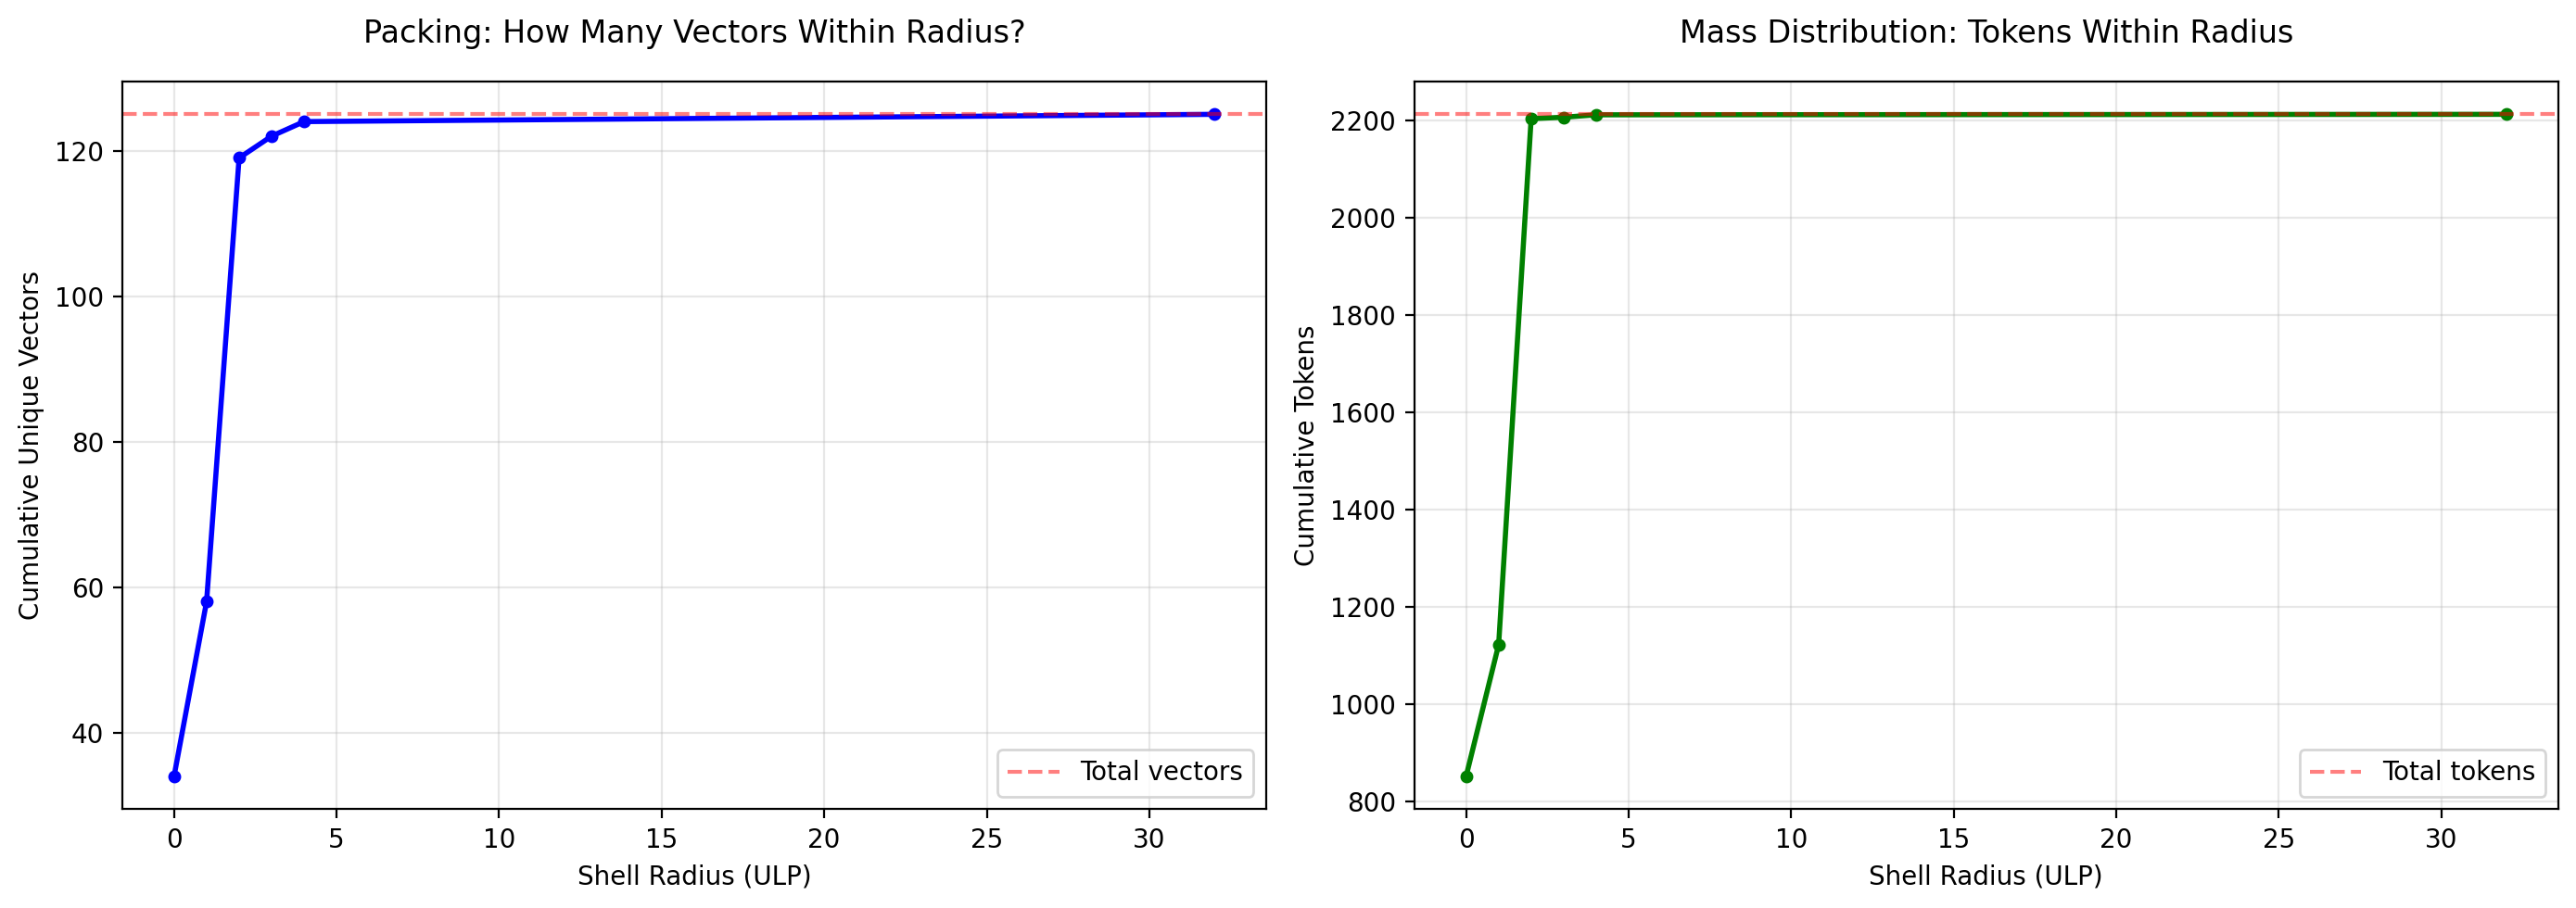


90% of unique vectors within: 2 ULP
90% of tokens within: 2 ULP


In [73]:
# Cumulative counts
cumulative_vectors = np.cumsum(counts)
cumulative_tokens = np.cumsum(pops)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Cumulative unique vectors
ax1.plot(shells, cumulative_vectors, 'o-', color='blue', linewidth=2, markersize=4)
ax1.axhline(len(unique_vectors), color='red', linestyle='--', alpha=0.5, label='Total vectors')
ax1.set_xlabel('Shell Radius (ULP)', color='black')
ax1.set_ylabel('Cumulative Unique Vectors', color='black')
ax1.set_title('Packing: How Many Vectors Within Radius?', color='black', pad=15)
ax1.tick_params(colors='black')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Cumulative tokens
ax2.plot(shells, cumulative_tokens, 'o-', color='green', linewidth=2, markersize=4)
ax2.axhline(len(cluster_token_ids), color='red', linestyle='--', alpha=0.5, label='Total tokens')
ax2.set_xlabel('Shell Radius (ULP)', color='black')
ax2.set_ylabel('Cumulative Tokens', color='black')
ax2.set_title('Mass Distribution: Tokens Within Radius', color='black', pad=15)
ax2.tick_params(colors='black')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Find radius containing 90% of vectors
r90_idx = np.argmax(cumulative_vectors >= 0.9 * len(unique_vectors))
r90_ulp = shells[r90_idx]

print(f'\n90% of unique vectors within: {r90_ulp} ULP')
print(f'90% of tokens within: {shells[np.argmax(cumulative_tokens >= 0.9 * len(cluster_token_ids))]} ULP')

## Detect Core Boundary

In [74]:
# Look for the largest gap in shell occupancy
# This would indicate transition from dense core to sparse halo

# Check for missing shells (gap = shell with zero vectors)
max_shell = max(shells)
all_shells = range(0, max_shell + 1)
missing_shells = [s for s in all_shells if s not in shells]

if missing_shells:
    print(f'Missing shells (zero occupancy): {missing_shells}')
    first_gap = min(missing_shells)
    print(f'\nFirst gap at radius {first_gap} ULP')
    print(f'This may indicate the core boundary.')
    
    # Count vectors before and after gap
    core_shells = [s for s in shells if s < first_gap]
    halo_shells = [s for s in shells if s >= first_gap]
    
    core_vectors = sum(shell_counts[s] for s in core_shells)
    halo_vectors = sum(shell_counts[s] for s in halo_shells)
    
    core_tokens = sum(shell_populations[s] for s in core_shells)
    halo_tokens = sum(shell_populations[s] for s in halo_shells)
    
    print(f'\nCore (r < {first_gap} ULP):')
    print(f'  Vectors: {core_vectors} ({100*core_vectors/len(unique_vectors):.1f}%)')
    print(f'  Tokens: {core_tokens} ({100*core_tokens/len(cluster_token_ids):.1f}%)')
    
    print(f'\nHalo (r ≥ {first_gap} ULP):')
    print(f'  Vectors: {halo_vectors} ({100*halo_vectors/len(unique_vectors):.1f}%)')
    print(f'  Tokens: {halo_tokens} ({100*halo_tokens/len(cluster_token_ids):.1f}%)')
else:
    print('No gaps in shell structure - all radii from 0 to max are occupied.')
    print('The cluster appears to be a continuous structure without clear core/halo boundary.')

Missing shells (zero occupancy): [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

First gap at radius 5 ULP
This may indicate the core boundary.

Core (r < 5 ULP):
  Vectors: 124 (99.2%)
  Tokens: 2211 (100.0%)

Halo (r ≥ 5 ULP):
  Vectors: 1 (0.8%)
  Tokens: 1 (0.0%)


## Fractional ULP Analysis

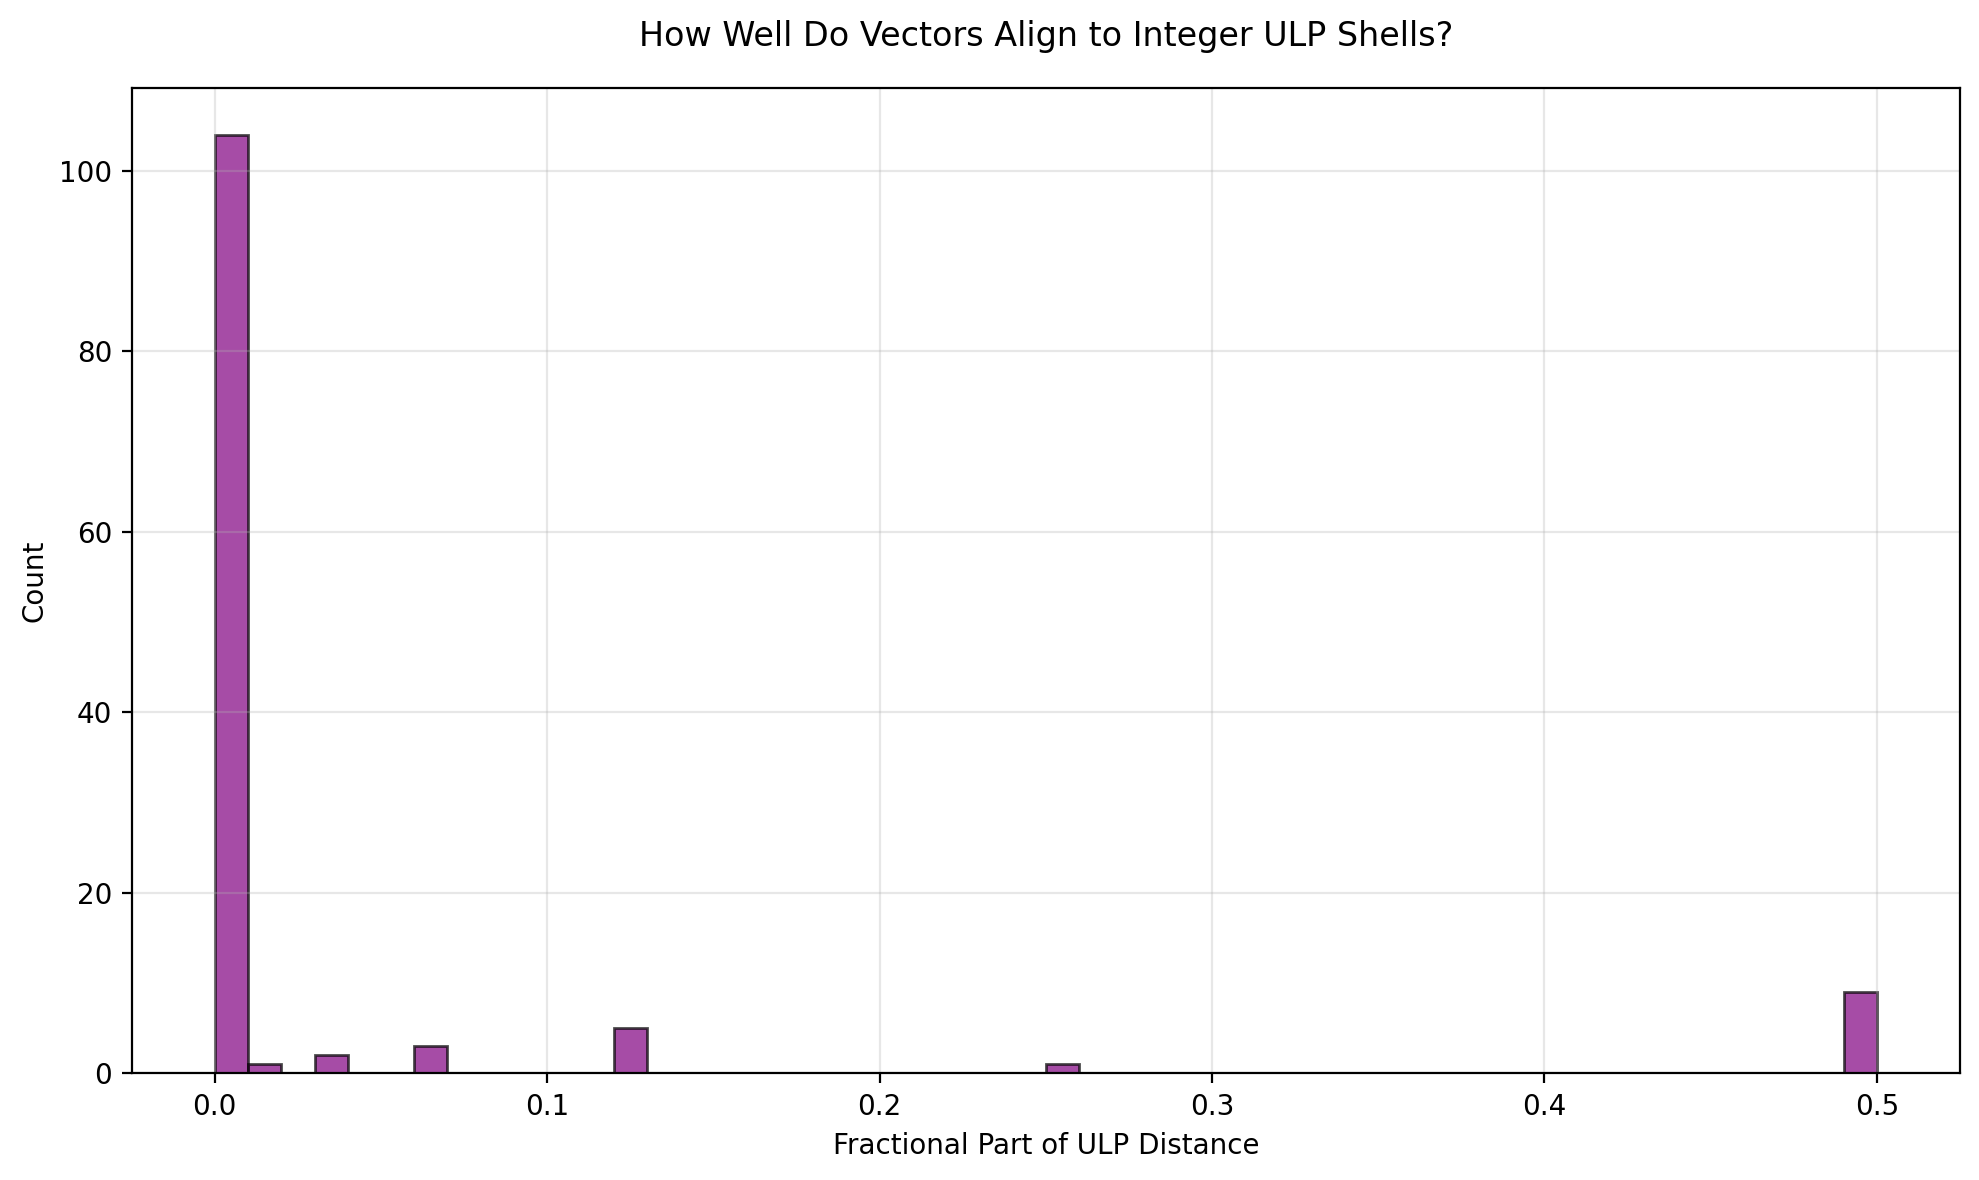


Vectors within 0.1 ULP of integer shell: 110 / 125 (88.0%)

~ Moderate lattice alignment - partial crystallization


In [75]:
# How close are distances to integer ULP values?
fractional_parts = np.abs(distances_in_ulp - np.round(distances_in_ulp))

fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

ax.hist(fractional_parts, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Fractional Part of ULP Distance', color='black')
ax.set_ylabel('Count', color='black')
ax.set_title('How Well Do Vectors Align to Integer ULP Shells?', color='black', pad=15)
ax.tick_params(colors='black')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_close_to_integer = np.sum(fractional_parts < 0.1)
print(f'\nVectors within 0.1 ULP of integer shell: {n_close_to_integer} / {len(unique_vectors)} '
      f'({100*n_close_to_integer/len(unique_vectors):.1f}%)')

if n_close_to_integer / len(unique_vectors) > 0.9:
    print('\n✓ Strong lattice alignment - most vectors sit at discrete ULP shells')
elif n_close_to_integer / len(unique_vectors) > 0.5:
    print('\n~ Moderate lattice alignment - partial crystallization')
else:
    print('\n✗ Weak lattice alignment - vectors are continuously distributed')

## Conclusion

In [76]:
print('='*70)
print('CRYSTALLIZATION ANALYSIS')
print('='*70)

print(f'\nStructure summary:')
print(f'  Origin: 814-token black hole (Big One)')
print(f'  Total unique vectors: {len(unique_vectors)}')
print(f'  Shell structure: {len(shells)} occupied shells')
print(f'  Radius range: 0 to {max(shells)} ULP')

if missing_shells:
    print(f'\n  Core radius: < {first_gap} ULP ({core_vectors} vectors, {core_tokens} tokens)')
    print(f'  Halo radius: ≥ {first_gap} ULP ({halo_vectors} vectors, {halo_tokens} tokens)')
    print(f'\n  INTERPRETATION: Clear core/halo structure detected')
else:
    print(f'\n  No obvious core/halo boundary (all shells occupied)')

alignment_fraction = n_close_to_integer / len(unique_vectors)
print(f'\nLattice alignment: {100*alignment_fraction:.1f}% of vectors near integer ULP shells')

if alignment_fraction > 0.9:
    print('\n✓ CRYSTALLIZED: The cluster froze into a discrete lattice structure')
    print('  Vectors are locked at specific ULP radii from the Big One')
elif alignment_fraction > 0.5:
    print('\n~ PARTIALLY CRYSTALLIZED: Mixed discrete/continuous structure')
    print('  Core may be crystalline while halo remains disordered')
else:
    print('\n✗ AMORPHOUS: No clear lattice structure detected')
    print('  Vectors appear continuously distributed')

print('\n' + '='*70)

CRYSTALLIZATION ANALYSIS

Structure summary:
  Origin: 814-token black hole (Big One)
  Total unique vectors: 125
  Shell structure: 6 occupied shells
  Radius range: 0 to 32 ULP

  Core radius: < 5 ULP (124 vectors, 2211 tokens)
  Halo radius: ≥ 5 ULP (1 vectors, 1 tokens)

  INTERPRETATION: Clear core/halo structure detected

Lattice alignment: 88.0% of vectors near integer ULP shells

~ PARTIALLY CRYSTALLIZED: Mixed discrete/continuous structure
  Core may be crystalline while halo remains disordered

